In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import cv2
from scipy.fft import fft, fftshift, fft2
from scipy.fft import fftfreq,rfft
from scipy.fft import rfftfreq, irfft,\
    ifft,ifftshift,ifft2,dct

from scipy import signal
from scipy import ndimage


from PIL import Image, \
    ImageDraw, ImageStat ,ImageOps
import cv2
import bisect
from numba import jit
import os


In [8]:

def make_subplots(args:list,titles:list ):
    assert len(args) == len(titles)
    
    fig = plt.figure(figsize=(18,12))
    for i in range(len(args)):
        ax_i = fig.add_subplot(1,len(args),i+1)
        ax_i.imshow(args[i],cmap="gray")
        ax_i.title.set_text(titles[i])
        
        ax_i.axis('off')
    
    plt.axis('off')
    plt.show()

# Задание 1
Дано:
1. Исходное изображение представлено в виде двумерной матрицы, записанной в формате Matlab в файле `A5_08_1.mat`.
2. Постройте заданное изображение в пространственной области, вычислите и отобразите на экране его амплитудный и фазовый спектр.
3. Используя свойство преобразования Фурье о сдвиге, выполните сдвиг изображения на 120 пикселей вправо и 10 пикселей вниз путем преобразования спектра в частотной области.
4. Вычислите амплитудный и фазовый спектр сдвинутого изображения. Отобразите на экране сдвинутое изображение и его спектр.
5. Проведите анализ и сравнение спектров исходного и сдвинутого изображений. Объясните полученные результаты. 
6. Рекомендация. При построении амплитудных спектров изображений целесообразно использовать логарифмическое преобразование яркости.

Сохраните все построенные изображения в формате jpg для представления в отчете с комментариями.


In [4]:
# Apply logarithmic transformation for an image  
def logTransformImage(image:Image, c_i=255):
    print(f"np.max(np.array(image)) {np.max(np.array(image))}")
    c = c_i / np.log(1 + np.max(np.array(image)))
    print(f"c={c}")
    log_image_arr = c * (np.log(np.array(image) + 1))
    print(f"log_image={np.max(log_image_arr)}")
    return  Image.fromarray(log_image_arr.astype('uint8'), 'RGB')

In [5]:
task = 1
SOURCE =os.path.join(os.getcwd(),r"Pictures")

OUTPUT= os.path.join(SOURCE,f"task_{task}_OUT")

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
file = os.path.join(SOURCE,"A5_08_1.mat")


MAT_RAW = np.loadtxt(file)
MAT_RAW_FIX =  MAT_RAW * 255
  
print(f"MAT_RAW: {MAT_RAW.shape}\nmax(MAT_RAW) = {MAT_RAW.max()}\nmin(MAT_RAW) = {MAT_RAW.min()}")
np.savetxt('MAT_RAW.txt', MAT_RAW, delimiter=',')

MAT_RAW: (200, 200)
max(MAT_RAW) = 1.0
min(MAT_RAW) = 0.0


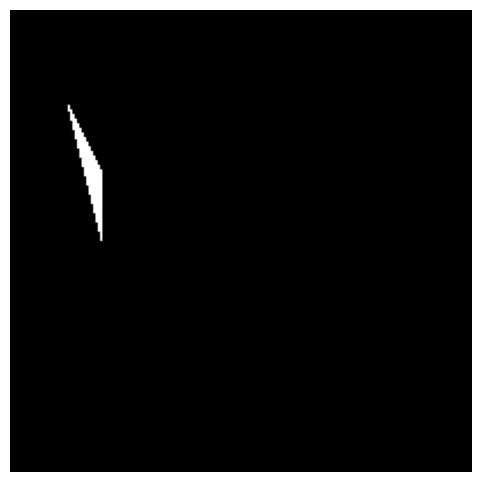

In [9]:
MAT = MAT_RAW_FIX.reshape(*MAT_RAW_FIX.shape).astype(np.uint8)

MAT = np.stack((MAT,) * 3, axis=-1)
image_raw = Image.fromarray(MAT)
image_raw.save(os.path.join(OUTPUT,"raw_image.png"))
%matplotlib inline
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(image_raw)

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_23692\3476059516.py:11: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
C:\Users\Dmitry\AppData\Local\Temp\ipykernel_23692\3476059516.py:20: RuntimeWarning: divide by zero encountered in log
  plt.subplot(142),plt.imshow(20*np.log(np.abs(f)), cmap='gray')


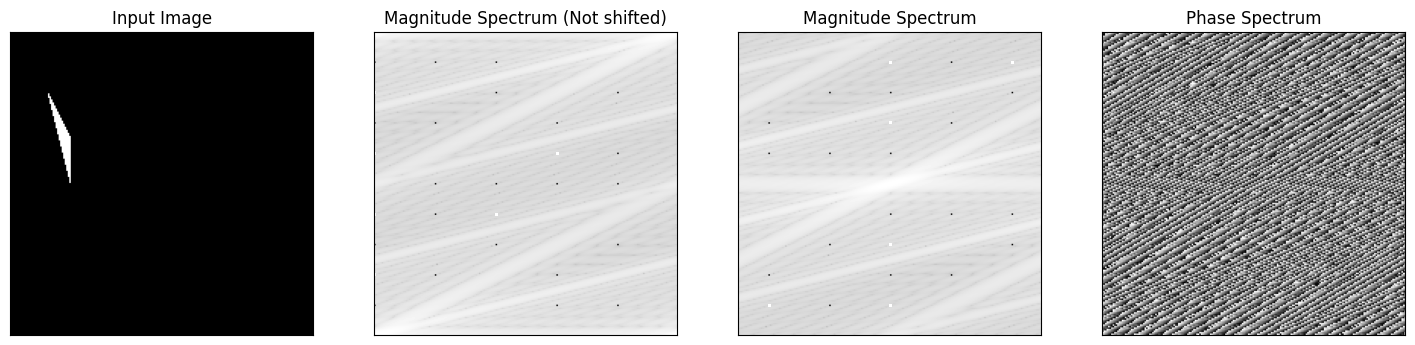

In [10]:
# загрузка изображения в оттенках серого
img = cv2.imread(os.path.join(OUTPUT,"raw_image.png"), 0)

# применение двумерного БПФ (Быстрое преобразование Фурье)
f = fft2(img)

# сдвиг низких частот к центру спектра 
fshift = fftshift(f)

# вычисление амплитудного спектра 
magnitude_spectrum = 20*np.log(np.abs(fshift))

# вычисление фазового спектра
phase_spectrum = np.angle(fshift)
plt.figure(figsize=(18,9))

plt.subplot(141),plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(142),plt.imshow(20*np.log(np.abs(f)), cmap='gray')
plt.title('Magnitude Spectrum (Not shifted)'), plt.xticks([]), plt.yticks([])

plt.subplot(143),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(144),plt.imshow(phase_spectrum, cmap='gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])

plt.savefig(os.path.join(OUTPUT,"InputPlots.png"))

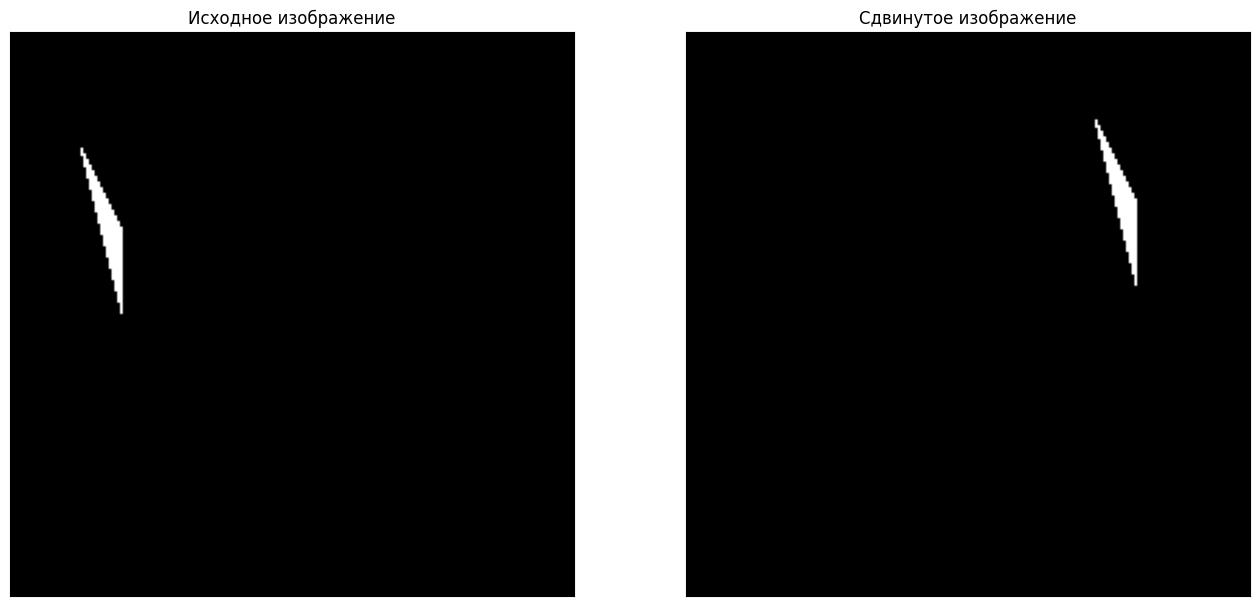

<Figure size 640x480 with 0 Axes>

In [11]:
# Расчет быстрого преобразования Фурье
f = fft2(img)

# Shift zero frequency to center
fshift = fftshift(f)

# Define the distance to shift along x and y axis
dx = 120
dy = -10

# Compute shift along x and y axis
M, N = img.shape
shiftx, shifty = np.meshgrid(np.arange(N), np.arange(M))
shiftx = np.exp(-2j * np.pi * dx * shiftx / N)
shifty = np.exp(-2j * np.pi * dy * shifty / M)

# Shift spectrum to perform shift in spatial domain
fshift = fshift * shiftx * shifty

# Inverse shift for visualizing the result image
f_ishift = ifftshift(fshift)

# Compute inverse fft of shifted spectrum
img_back = ifft2(f_ishift)

# Take the absolute value of the complex result to get the real image
img_back = np.abs(img_back)



# Отображение измененного изображения
plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Сдвинутое изображение'), plt.xticks([]), plt.yticks([])
plt.show()

plt.savefig(os.path.join(OUTPUT,"CompareInputShifted.png"))

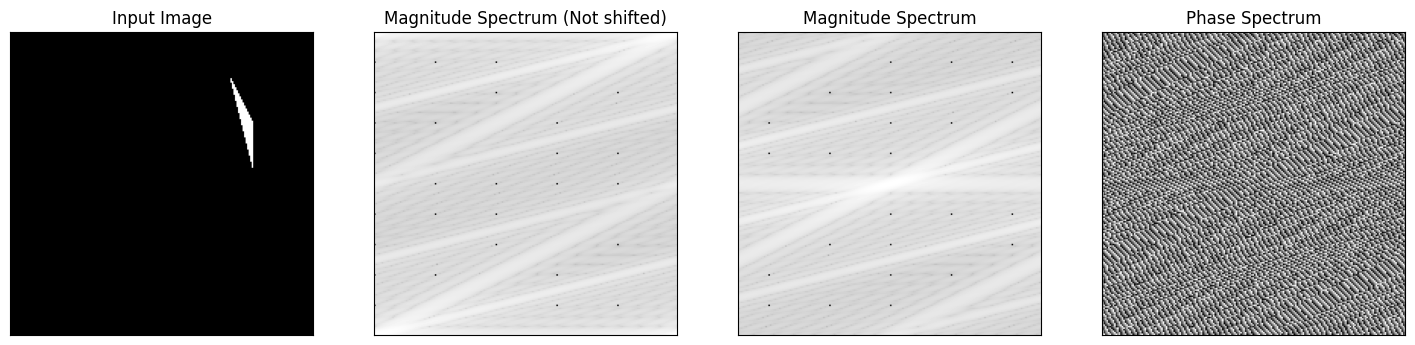

In [12]:
# применение двумерного БПФ (Быстрое преобразование Фурье)
f = fft2(img_back)

# сдвиг низких частот к центру спектра 
fshift = fftshift(f)

# вычисление амплитудного спектра 
magnitude_spectrum = 20*np.log(np.abs(fshift))

# вычисление фазового спектра
phase_spectrum = np.angle(fshift)

plt.figure(figsize=(18,9))

plt.subplot(141),plt.imshow(img_back, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(142),plt.imshow(20*np.log(np.abs(f)), cmap='gray')
plt.title('Magnitude Spectrum (Not shifted)'), plt.xticks([]), plt.yticks([])

plt.subplot(143),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(144),plt.imshow(phase_spectrum, cmap='gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])

plt.savefig(os.path.join(OUTPUT,"ShiftedPlots.png"))

# Задание 2.
1.  Считываем исходное изображение;
2. Построим центрированный спектр изображения, в котором нулевая частота располагается в центре частотной области путем преобразования исходного изображения в пространственной области;
3. Построим центрированный спектр изображения путем преобразований изображения в частотной области;
4. С помощью обратного преобразования Фурье построим изображение в пространственной области, соответствующее центрированному спектру изображения в частотной области.

Преобразование изображения в пространственной области означает изменение яркости каждого пикселя на основе его окружающих пикселей. Это может быть выполнено с помощью различных фильтров, таких как фильтр Гаусса или медианный фильтр.

Преобразование изображения в частотной области означает перевод исходного изображения в новое представление, где информация хранится не по координатам x и y, а по частотам. Для этого используется прямое преобразование Фурье (FFT). В результате получается спектральное представление изображения.

Чтобы получить центрированный спектр изображения, нужно выполнить следующие шаги:
1. Применить преобразование Фурье к исходному изображению.
2. Перенести квадрант с нулевой частотой из левого верхнего угла в центр спектра.
3. Перепоручить оставшиеся квадранты спектра так, чтобы левый верхний квадрант соответствовал отрицательным частотам по обеим осям.

In [14]:
task = 2

SOURCE =os.path.join(os.getcwd(),r"Pictures")

OUTPUT= os.path.join(SOURCE,f"task_{task}_OUT")

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
file = os.path.join(SOURCE,"A5_08_1.mat")


MAT_RAW = np.loadtxt(file)
MAT_RAW_FIX =  MAT_RAW * 255
  
print(f"MAT_RAW: {MAT_RAW.shape}\nmax(MAT_RAW) = {MAT_RAW.max()}\nmin(MAT_RAW) = {MAT_RAW.min()}")
np.savetxt('MAT_RAW.txt', MAT_RAW, delimiter=',')

MAT_RAW: (200, 200)
max(MAT_RAW) = 1.0
min(MAT_RAW) = 0.0


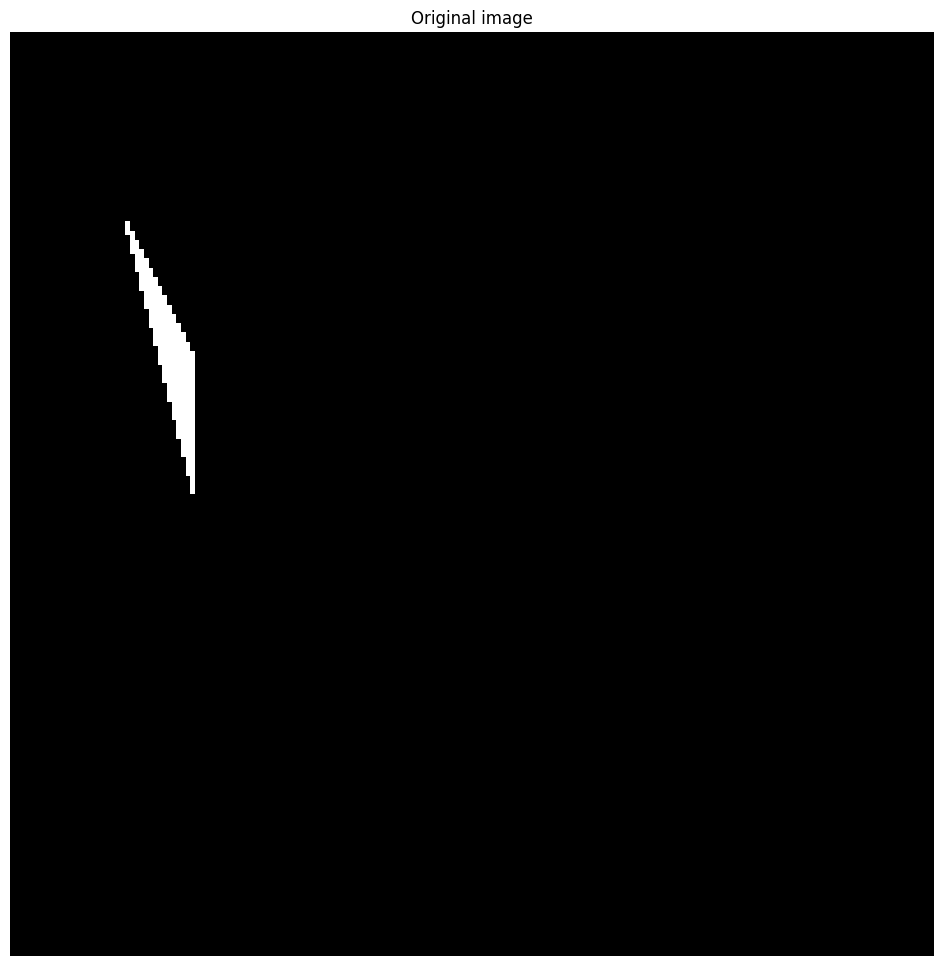

In [15]:
def F_chess_2D(height, width):
    chessboard = np.indices((height, width)).sum(axis=0) % 2
    return chessboard

# Чтение изображения
M = np.loadtxt(file)
sz = np.shape(M)
sy = sz[0]  # высота
sx = sz[1]  # ширина
CH = F_chess_2D(sy, sx)  # Предполагается, что у вас есть реализация функции F_chess_2D

# Спектр, центрированный в пространственной области
RF = fft2(M * CH)

# Исходное изображение
plt.figure('Original image',figsize=(12,12))
plt.imshow(M, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"InputIm"))

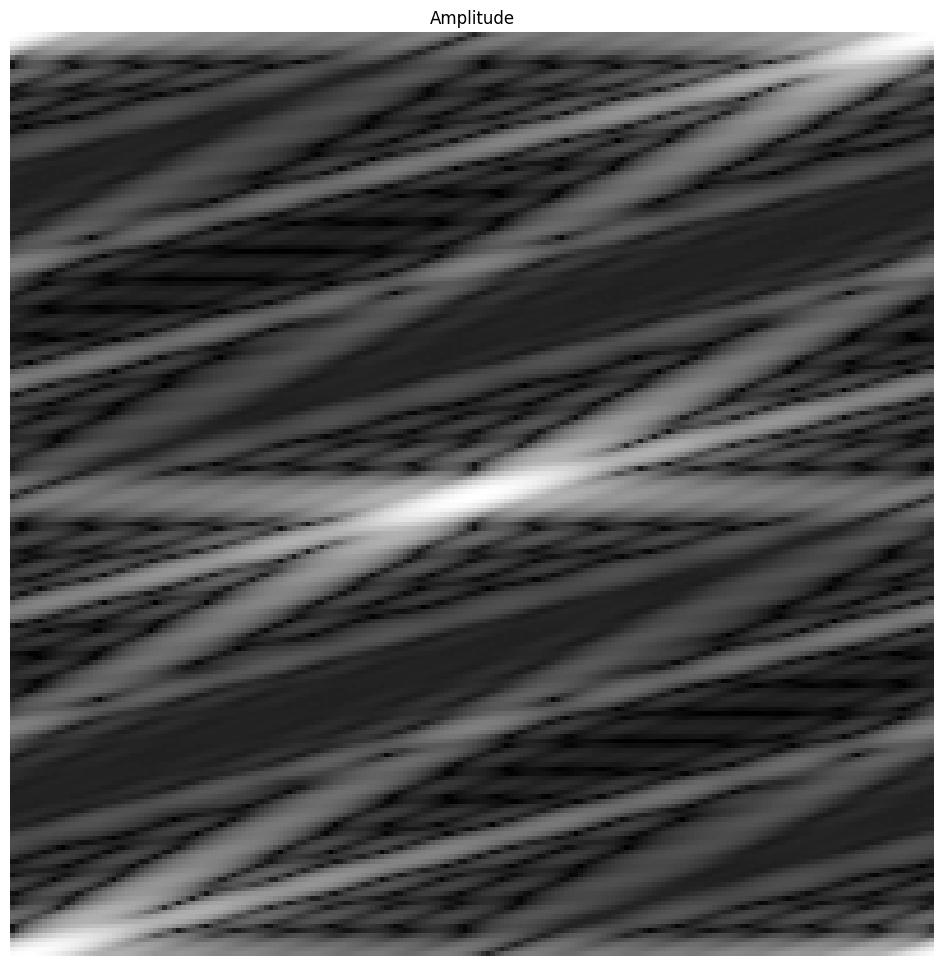

In [16]:
# Амплитуда
plt.figure('Amplitude',figsize=(12,12))
plt.axis('off')
plt.imshow(np.log(1 + np.abs(RF)), cmap='gray')
plt.title('Amplitude')
plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"InputAmplitude"))

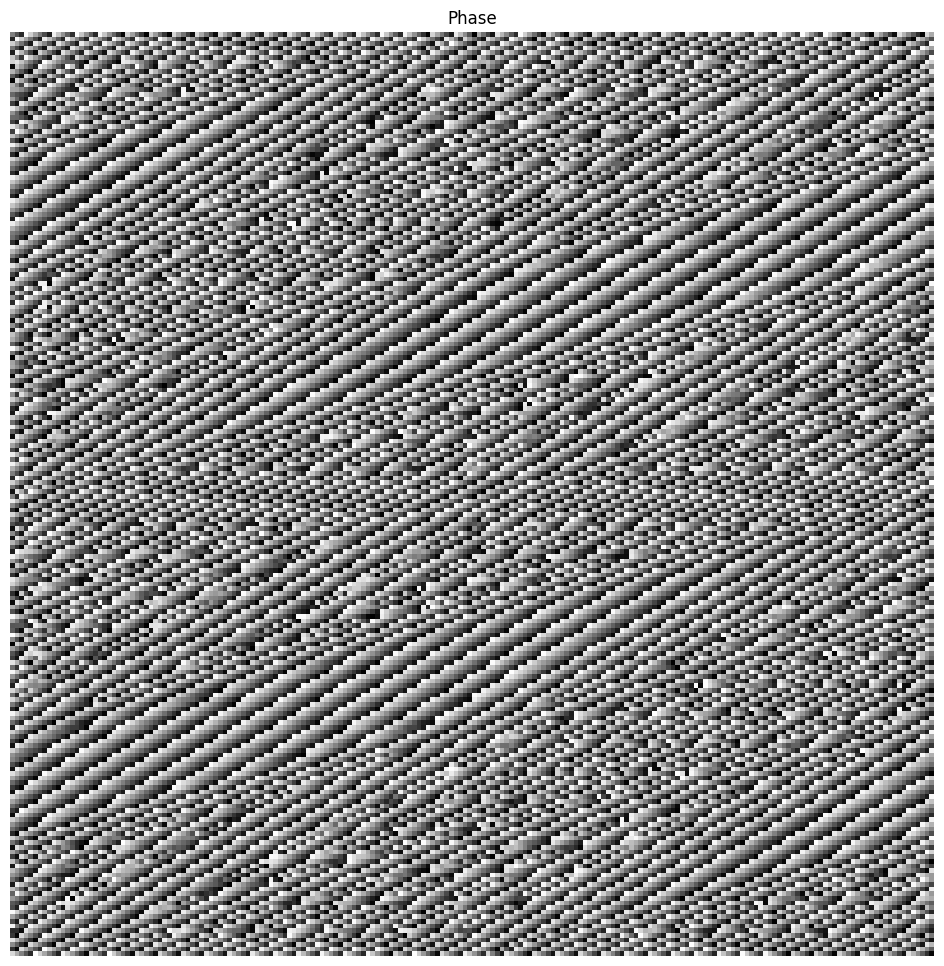

In [18]:
# Фаза
plt.figure('Phase',figsize=(12,12)) 
plt.imshow(np.angle(RF), cmap='gray')
plt.title('Phase')
plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"InputPhase"))

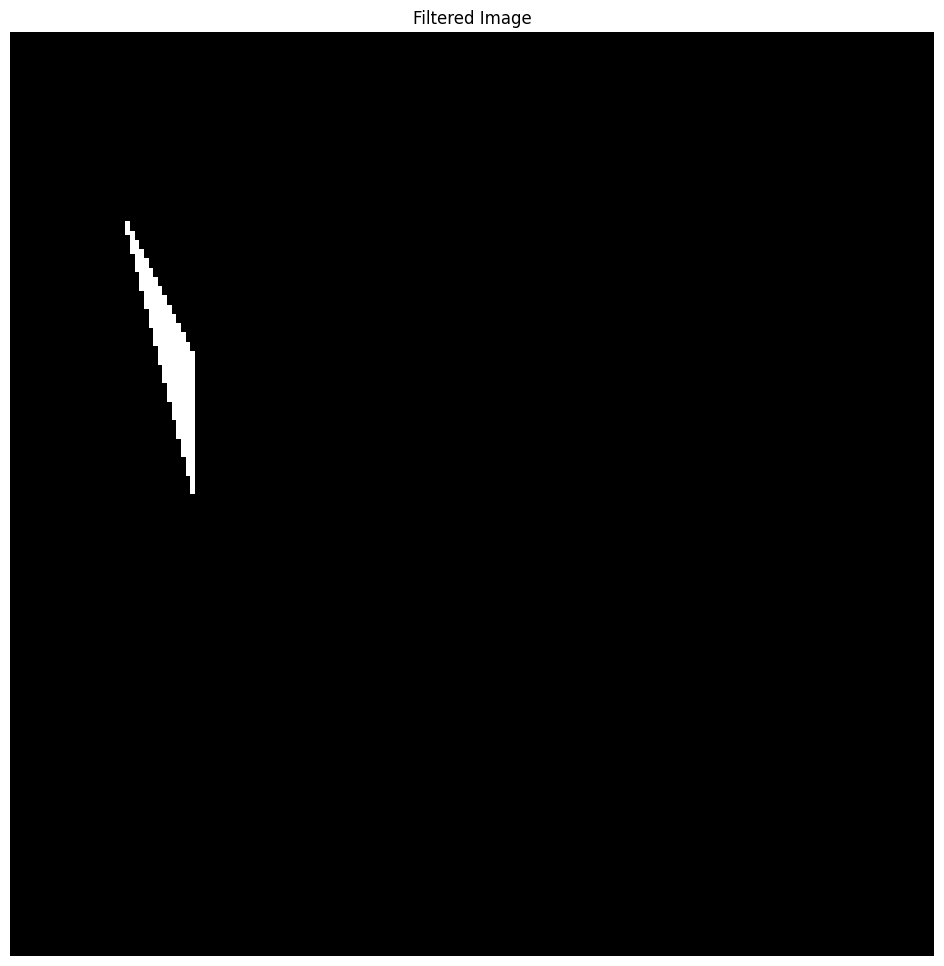

In [19]:
# Спектр, центрированный в частотной области
RF1 = fft2(M)
ksdvm = 100
ksdvn = 100
FIMsdv = RF1.copy()

for im in range(sy):
    for in_ in range(sx):
        if im - ksdvm >= 0 and in_ - ksdvn >= 0:
            FIMsdv[im, in_] = RF1[im - ksdvm, in_ - ksdvn]
        elif im - ksdvm >= 0:
            FIMsdv[im, in_] = RF1[im - ksdvm, sx - ksdvn + in_]
        elif in_ - ksdvn >= 0:
            FIMsdv[im, in_] = RF1[sy - ksdvm + im, in_ - ksdvn]
        else:
            FIMsdv[im, in_] = RF1[sy - ksdvm + im, sx - ksdvn + in_]

SIM = ifft2(FIMsdv)
plt.figure(figsize=(12,12))
plt.imshow(np.abs(SIM), cmap='gray')
plt.axis('off')
plt.title('Filtered Image')
plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"FilteredInput"))


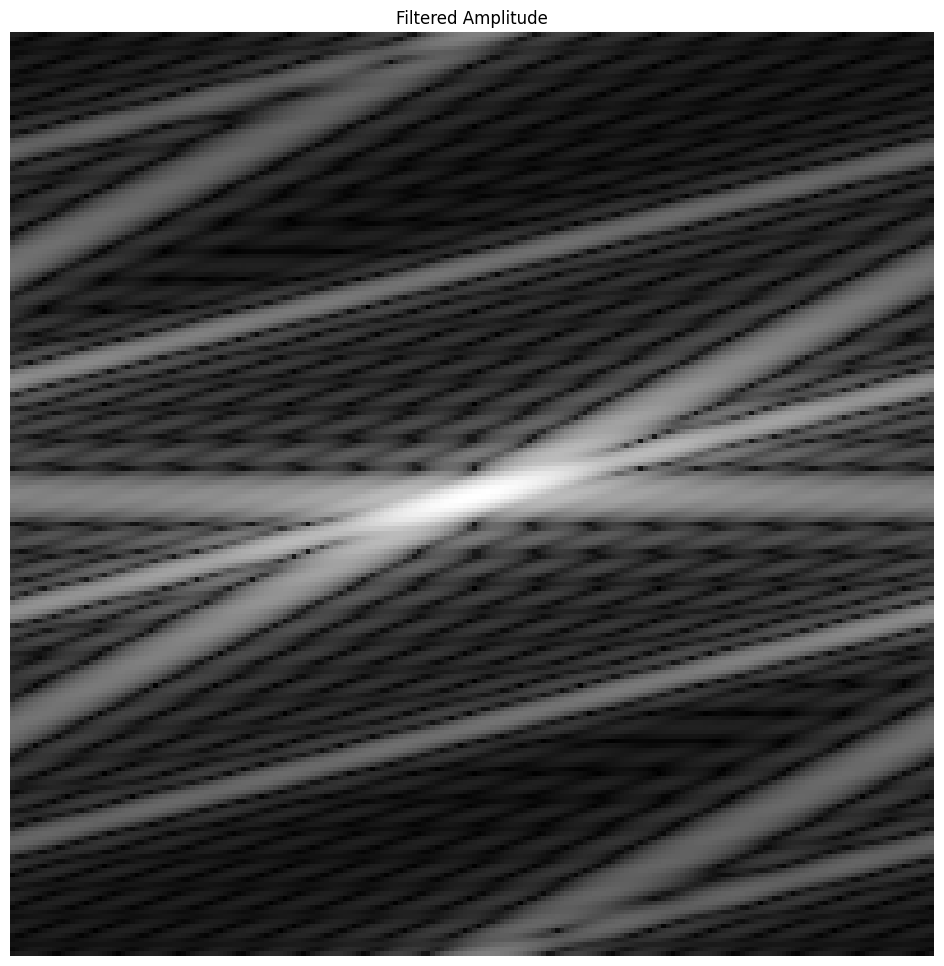

In [20]:
RF2 = np.fft.fft2(SIM)
plt.figure(figsize=(12,12)) 
plt.imshow(np.log(1 + np.abs(RF2)), cmap='gray')
plt.title('Filtered Amplitude')
plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"FilteredInputAmplitude"))

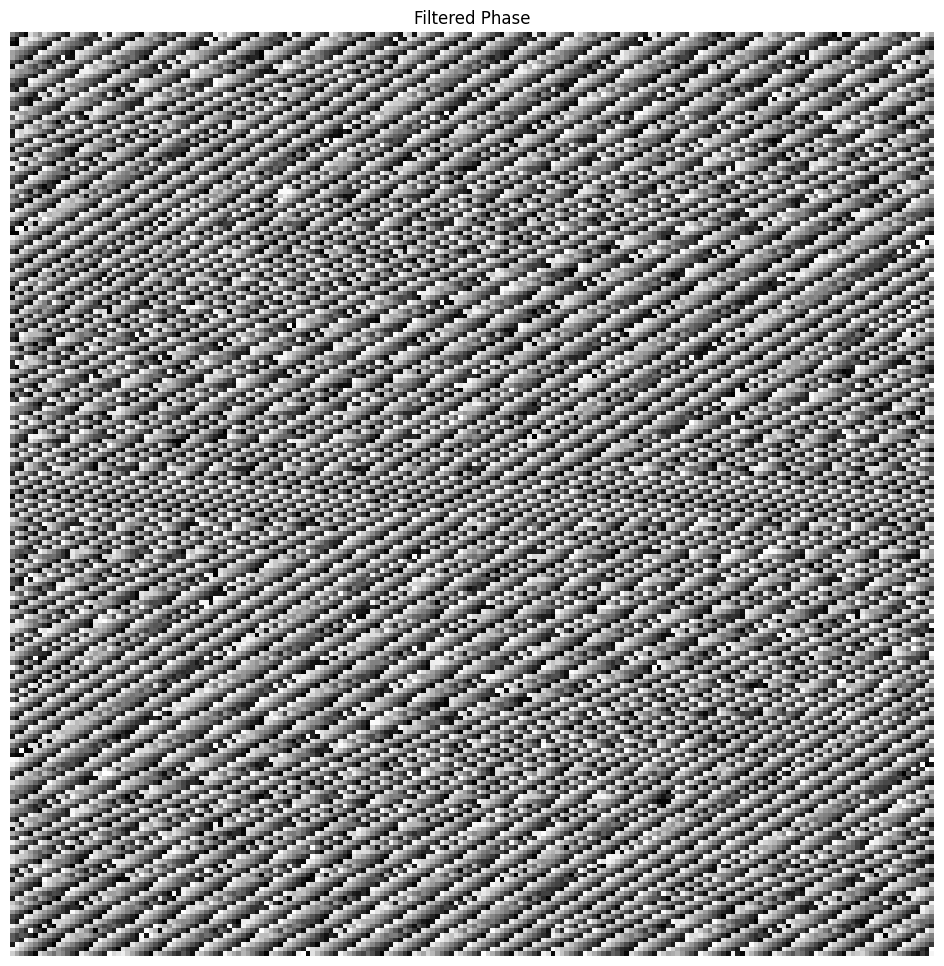

In [21]:
plt.figure(figsize=(12,12))
plt.imshow(np.angle(RF2), cmap='gray')
plt.title('Filtered Phase')


plt.axis("off")
plt.savefig(os.path.join(OUTPUT,"FilteredInputPhase"))

plt.show()

# Задание 3
Дано текстовое изображение, представленное файлом *`A5_08_3.jpg`*. Выполните с этим изображением следующие операции:
1. Вычислите спектр изображения и на экране отобразите его абсолютное значение в центрированном виде.
2. Выполните расфокусировку изображения с помощью `фильтра нижних частот` (ФНЧ), в качестве которого используйте фильтр Баттерворта второго порядка с частотой среза на уровне 50 пикселей.
3. Для расфокусированного изображения с целью повышения резкости выполните фильтрацию с помощью Лапласиана в частотной области. Частотную характеристику фильтра Лапласиана постройте путем двумерного `ДПФ` от маски Лапласиана 3х3 в пространственной области.
**Рекомендация**. С целью улучшения эффективности повышения резкости изображения при фильтрации используйте двух- или трехкратное последовательное применение фильтра Лапласиана. Конечный результат фильтрации для улучшения контраста изображения подвергните нелинейному преобразованию с помощью гамма-коррекции или логарифмического преобразования яркости в комбинации с эквализацией гистограммы.
4. С целью выделения контуров объектов на изображении выполните фильтрацию исходного изображения с помощью фильтра верхних частот (ФВЧ). В качестве ФВЧ используйте гауссов фильтр.
Рекомендация. Частоту среза ФВЧ выберите около 200 пикселей.

Сохраните все построенные изображения в формате jpg для представления в отчете с комментариями.

c:\Users\Dmitry\Desktop\M8\Matlab\PythonLabsDIP\LW_5


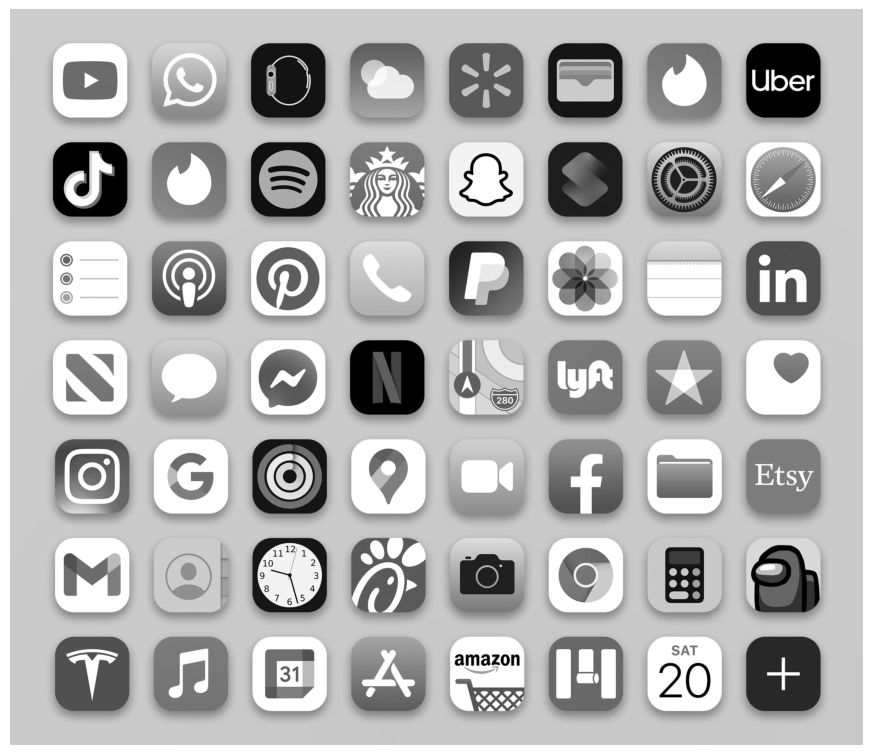

In [38]:
task_3= 3

NAME_PIC = r"A5_08_3.jpg"
cwd = os.getcwd()
print(cwd)
SOURCE_PIC  = os.path.join(cwd,"Pictures", NAME_PIC)
task_1 = 1
OUTPUT_DIR_3 = os.path.join(cwd,f"task_{task_3}")
if not os.path.exists(OUTPUT_DIR_3):
    os.makedirs(OUTPUT_DIR_3)
    

img_source =   Image.open(SOURCE_PIC).convert('L')

plt.figure(figsize=(11,11))
plt.imshow(img_source,cmap='gray')

plt.axis('off')
plt.savefig(os.path.join(OUTPUT_DIR_3,"Input"))

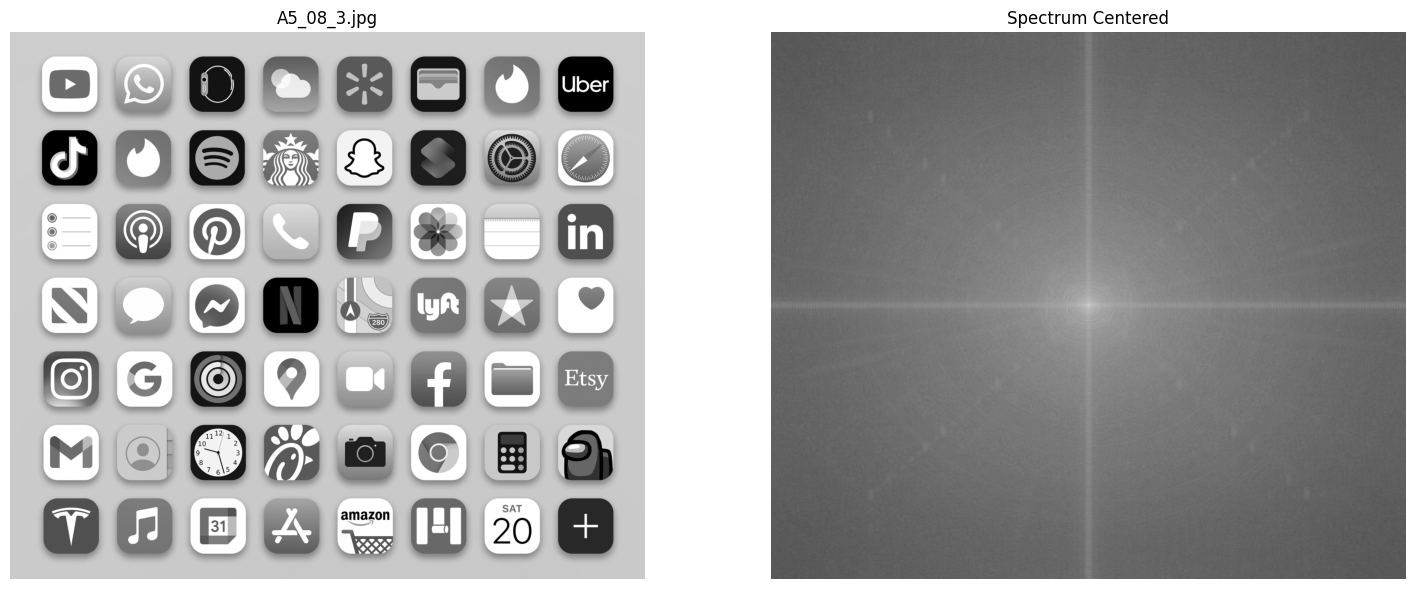

In [39]:

# Aply fft2 to image
f = fft2(img_source)
# Shift
f_shift = fftshift(np.abs(f))


make_subplots(
    [
        img_source,20 * np.log(f_shift)
    ],
    
    [
        "A5_08_3.jpg" ,"Spectrum Centered"
    ]
)

# Convert image mode to grayscale
image_gray = np.abs(20 * np.log(f_shift)).astype(np.uint8)

# Create PIL Image object
image_pil = Image.fromarray(image_gray, mode='L')

# Save the image as JPEG
image_pil.save(os.path.join(OUTPUT_DIR_3, "Input_Spectrum.jpg"))


Apply Butterworth low pass filter using the below code. (URL: https://stackoverflow.com/questions/58412102/how-to-implement-a-butterworth-filter-over-a-2d-np-array-of-a-medical-image-in-p )

In [11]:
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2
from scipy import fftpack


def butterworth_filter(image, cutoff_frequency, order):
    # Размеры изображения
    sy, sx = image.size
    sx2, sy2 = sx // 2, sy // 2

    # Создание фильтра Баттерворта
    HB = np.zeros((sy, sx))
    for im in range(sy):
        for in_ in range(sx):
            dt = np.sqrt((in_ - sx2) ** 2 + (im - sy2) ** 2)
            HB[im, in_] = 1 / (1 + (dt / cutoff_frequency) ** (2 * order))

    # Применение фильтра к спектру изображения
    FB = fft2(image)
    G0 =  np.abs(
        ifft2(
            signal.fftconvolve(FB,fft2(HB),
            mode="same"
            )
            )
        )

    return G0

def high_pass_filter(image, cutoff_frequency):
    # Применение двумерного дискретного 
    # преобразования Фурье (ДПФ) к изображению
    image_frequency = fft2(image)
    
    # Центрирование нулевой частоты
    image_frequency_shifted = fftshift(image_frequency)
    
    # Создание фильтра верхних 
    # частот (гауссов фильтр)
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    x = np.arange(cols) - center_col
    y = np.arange(rows) - center_row
    xx, yy = np.meshgrid(x, y)
    filter_mask = np.exp(-((xx ** 2 + yy ** 2) \
                           / (2 * cutoff_frequency ** 2)))
    
    # Применение фильтра верхних 
    # частот к спектру изображения
    filtered_frequency_shifted = image_frequency_shifted * (1 - filter_mask)
    
    # Обратное преобразование Фурье 
    # для получения отфильтрованного изображения
    filtered_frequency = ifftshift(filtered_frequency_shifted)
    filtered_image = ifft2(filtered_frequency)
    filtered_image = np.abs(filtered_image)
    
    # Масштабирование значений 
    # пикселей в диапазон от 0 до 255
    filtered_image = (filtered_image - np.min(filtered_image)) \
        / (np.max(filtered_image) - np.min(filtered_image))
    filtered_image = (filtered_image * 255).astype(np.uint8)
    
    return filtered_image

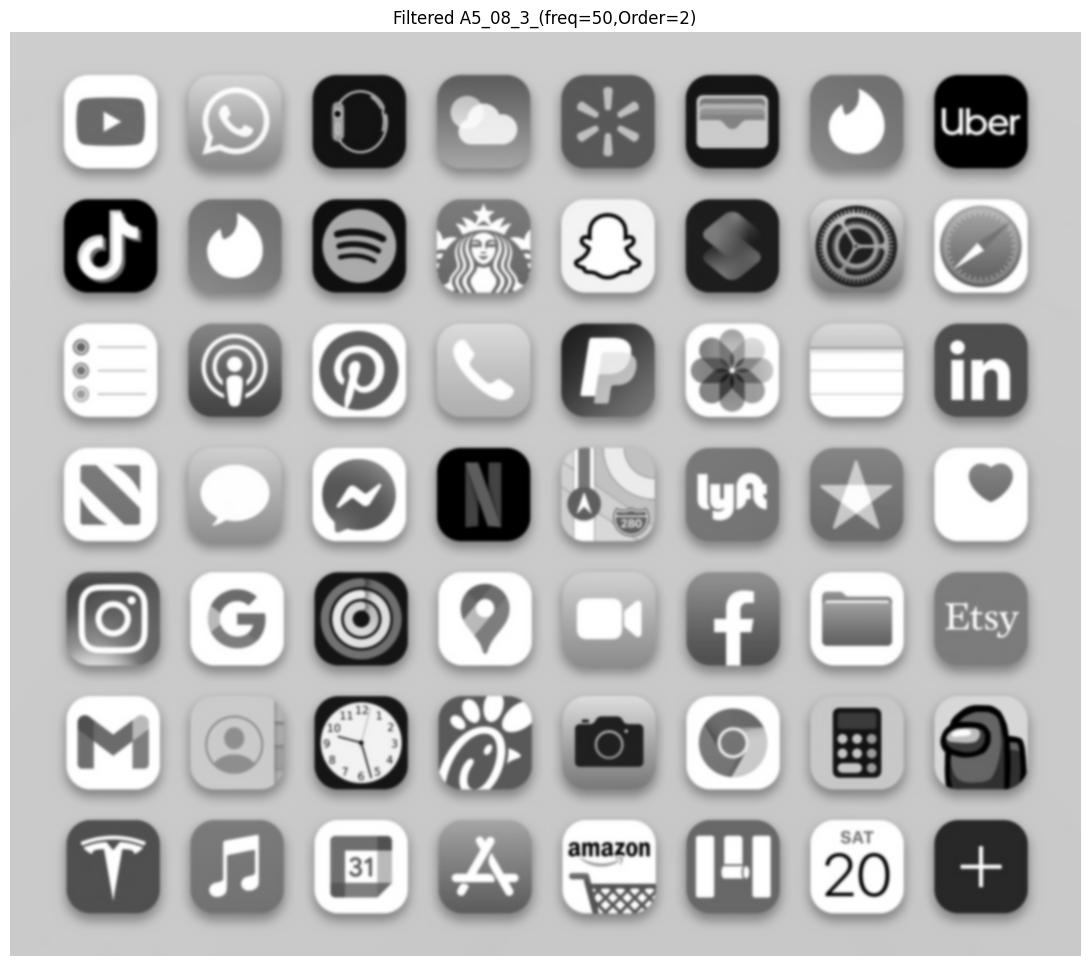

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_24152\3744249320.py:17: RuntimeWarning: divide by zero encountered in log
  image_gray = np.abs(20 * np.log(filt_image)).astype(np.uint8)
C:\Users\Dmitry\AppData\Local\Temp\ipykernel_24152\3744249320.py:17: RuntimeWarning: invalid value encountered in cast
  image_gray = np.abs(20 * np.log(filt_image)).astype(np.uint8)


In [40]:
from scipy.ndimage import gaussian_filter
W = 50  # Частота среза фильтра в пикселях
N  = 2 # порядок
filt_image = gaussian_filter(img_source,sigma=3)
make_subplots(
    [
        # img_source,
        filt_image,
    ],
    
    [
        # "input",
        f"Filtered A5_08_3_(freq={W},Order={N})",
    ]
)
# Convert image mode to grayscale
image_gray = np.abs(20 * np.log(filt_image)).astype(np.uint8)

# Create PIL Image object
image_pil = Image.fromarray(image_gray, mode='L')

# Save the image as JPEG
image_pil.save(os.path.join(OUTPUT_DIR_3, f"Filtered_A5_08_3.jpg"))

In [41]:
def apply_laplacian_filter(
    image, 
    iterations,
    dimension:int=3,
    center_value:int=4):
    filtered_image = image.copy()
    for i in range(iterations):
        # Применение преобразования Фурье
        f = np.fft.fft2(filtered_image)
        fshift = np.fft.fftshift(f)
        
        # Создание маски Лапласиана в частотной области
        mask = laplacian_mask(dimension,center_value)
        # Применение маски Лапласиана
        fshift_filtered = signal.fftconvolve(
            fshift, 
            mask,
            "same")
        
        # Обратное преобразование Фурье
        f_ishift = np.fft.ifftshift(fshift_filtered)
        filtered_image = np.fft.ifft2(f_ishift)
        filtered_image = np.abs(filtered_image)
    
    return filtered_image

def laplacian_mask(size, center_value):
    center = (size - 1) // 2
    mask = np.ones((size, size)) * (-np.sign(center_value))
    mask[center, center] = center_value
    return mask

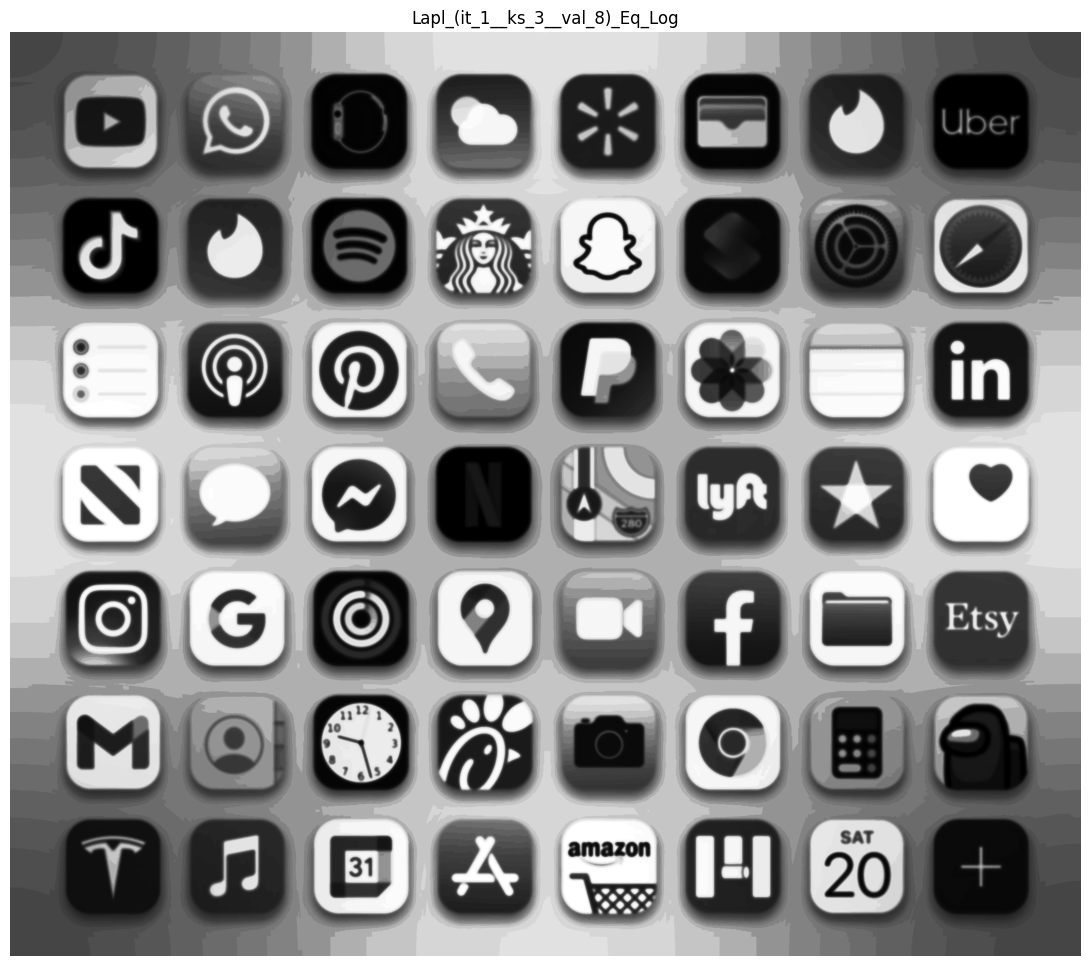

In [42]:
iterations = 1
# Применение фильтра Лапласиана

# Параметры
lapl_img = filt_image
ksize = 3
val = 8
# Применение
lapl_img = apply_laplacian_filter(
    lapl_img,
    iterations=iterations,
    dimension=ksize,
    center_value=32)


# Повышение контраста изображения 
# с помощью гамма-коррекции или эквализации гистограммы
c = 255 / np.log(1 + np.max(lapl_img))
log_image = c * (np.log(lapl_img + 1))
log_image = np.array(log_image)

# Преобразование типа данных в uint8
log_image = log_image.astype(np.uint8)

# Эквализация гистограммы
enhanced_image = cv2.equalizeHist(log_image)

make_subplots(
    [
        #filt_image,
        enhanced_image
    ],
    [
        #f"Filtered(f={W},Or={N})",
        f"Lapl_(it_{iterations}__ks_{ksize}__val_{val})_Eq_Log"
    ]
)
Image.fromarray(enhanced_image).save(
    os.path.join(
        OUTPUT_DIR_3,
        f"Lapl_(it_{iterations}__ks_{ksize}__val_{val})_Eq_Log.png"
        )
    )

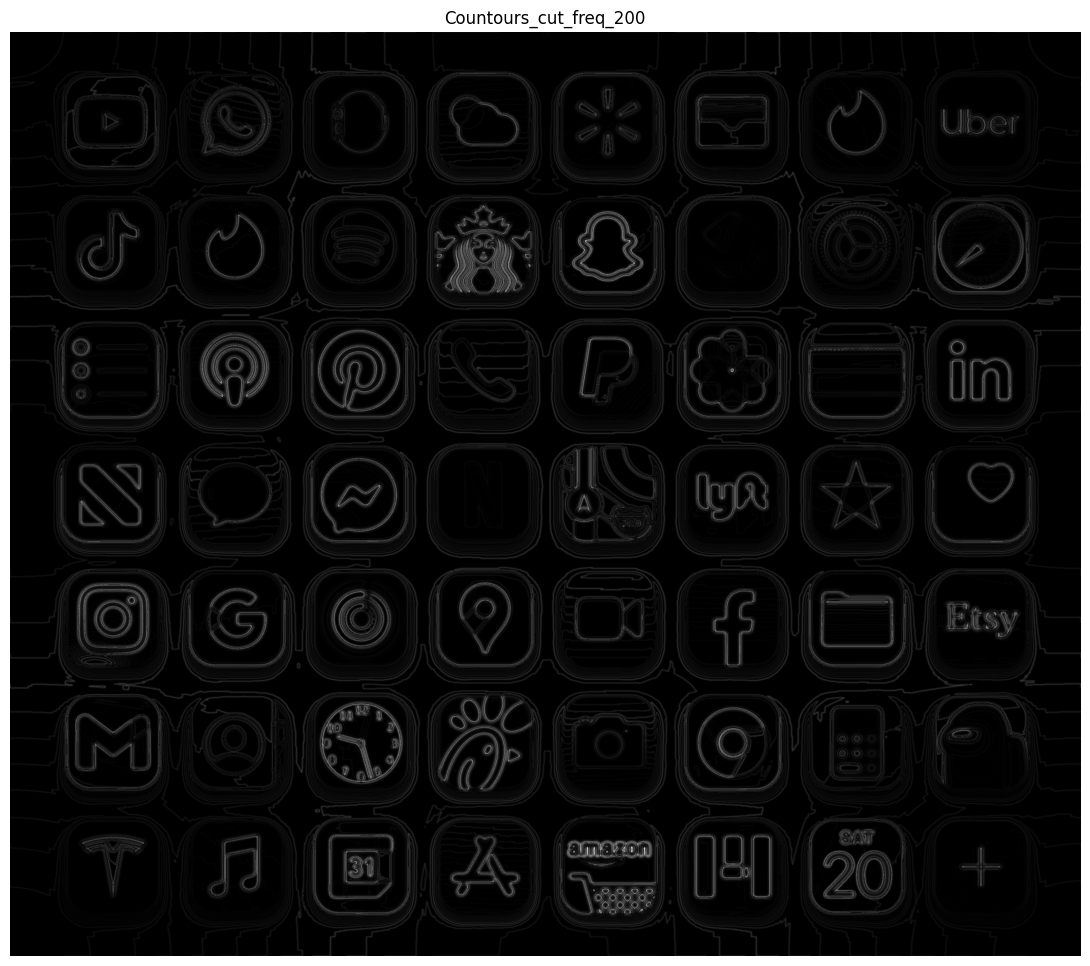

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_24152\1008206154.py:19: RuntimeWarning: divide by zero encountered in log
  image_gray = np.abs(20 * np.log(
C:\Users\Dmitry\AppData\Local\Temp\ipykernel_24152\1008206154.py:20: RuntimeWarning: invalid value encountered in cast
  image_contours)).astype(np.uint8)


In [43]:
freq_cut = 200
# Примените фильтр Гаусса к исходному изображению:
image_contours = high_pass_filter(
    enhanced_image,
    cutoff_frequency=freq_cut
    )

make_subplots(
    [
        #enhanced_image, 
        image_contours
        ],
    [
        #f"Lapl(it={iterations})_Eq_Log",
        f"Countours_cut_freq_{freq_cut}"
        ]
)
# Convert image mode to grayscale
image_gray = np.abs(20 * np.log(
    image_contours)).astype(np.uint8)

# Create PIL Image object
image_pil = Image.fromarray(image_gray, mode='L')

# Save the image as JPEG
image_pil.save(
    os.path.join(
        OUTPUT_DIR_3, 
        f"Countours_cut_freq_{freq_cut}.jpg"
        )
    )